In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
df_16 = pd.read_csv("aggregated_data/Antananarivo_2016_3x3_windows.csv")
df_23 = pd.read_csv("aggregated_data/Antananarivo_2023_3x3_windows.csv")
# df_16 = pd.read_csv("aggregated_data/Mumbai_2016_3x3_windows.csv")
# df_23 = pd.read_csv("aggregated_data/Mumbai_2023_3x3_windows.csv")
# df_16 = pd.read_csv("aggregated_data/Mexico City_2016_3x3_windows.csv")
# df_23 = pd.read_csv("aggregated_data/Mexico City_2023_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")

In [4]:
df_16.head()
#plt.plot(df_16['remoteness'],df_16['building_count'])

,center_row,center_col,center_longitude,center_latitude,building_count,avg_height,distance_to_center
0,1,1,47.342069,-18.736027,0,0.0,27.490379
1,1,2,47.342159,-18.736027,0,0.0,27.483880
2,1,3,47.342249,-18.736027,0,0.0,27.477383
3,1,4,47.342338,-18.736027,0,0.0,27.470887
4,1,5,47.342428,-18.736027,0,0.0,27.464393


In [5]:
df_16.shape

(15992001, 7)

In [6]:
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_16_UN'].iloc[0] * 1000
pop_23 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_23_UN'].iloc[0] * 1000
# pop_16 = cities.loc[cities['Name'] == 'Mumbai', 'pop_16_UN'].iloc[0] * 1000
# pop_23 = cities.loc[cities['Name'] == 'Mumbai', 'pop_23_UN'].iloc[0] * 1000
# pop_16 = cities.loc[cities['Name'] == 'Mexico City', 'pop_16_UN'].iloc[0] * 1000
# pop_23 = cities.loc[cities['Name'] == 'Mexico City', 'pop_23_UN'].iloc[0] * 1000
df_16['remoteness'] = (df_16['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_23['remoteness'] = (df_23['distance_to_center'] / np.sqrt(pop_23)) * 1000

In [13]:
df = df_16.copy()

## Zero inflated Poisson

In [29]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson

np.random.seed(72)
df = df_16.sample(n=100000).copy()
# df = df_16.copy()

# 构建设计矩阵（添加常数项
X = sm.add_constant(df["remoteness"])
y = df["building_count"]

# 构建 ZIP 模型（inflation 部分也使用 remoteness）
zip_model = ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit')

# 拟合模型
zip_result_16 = zip_model.fit(method='bfgs', maxiter=100, disp=True)

# 输出模型摘要
print(zip_result_16.summary())

Optimization terminated successfully.
         Current function value: 0.447075
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          building_count   No. Observations:               100000
Model:             ZeroInflatedPoisson   Df Residuals:                    99998
Method:                            MLE   Df Model:                            1
Date:                 Thu, 07 Aug 2025   Pseudo R-squ.:                 0.01945
Time:                         12:01:31   Log-Likelihood:                -44707.
converged:                        True   LL-Null:                       -45594.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const 

In [30]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson

np.random.seed(72)
df = df_23.sample(n=100000).copy()
# df = df_16.copy()

# 构建设计矩阵（添加常数项
X = sm.add_constant(df["remoteness"])
y = df["building_count"]

# 构建 ZIP 模型（inflation 部分也使用 remoteness）
zip_model = ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit')

# 拟合模型
zip_result_23 = zip_model.fit(method='bfgs', maxiter=100, disp=True)

# 输出模型摘要
print(zip_result_23.summary())

Optimization terminated successfully.
         Current function value: 0.423576
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          building_count   No. Observations:               100000
Model:             ZeroInflatedPoisson   Df Residuals:                    99998
Method:                            MLE   Df Model:                            1
Date:                 Thu, 07 Aug 2025   Pseudo R-squ.:                 0.02082
Time:                         12:01:35   Log-Likelihood:                -42358.
converged:                        True   LL-Null:                       -43258.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const 

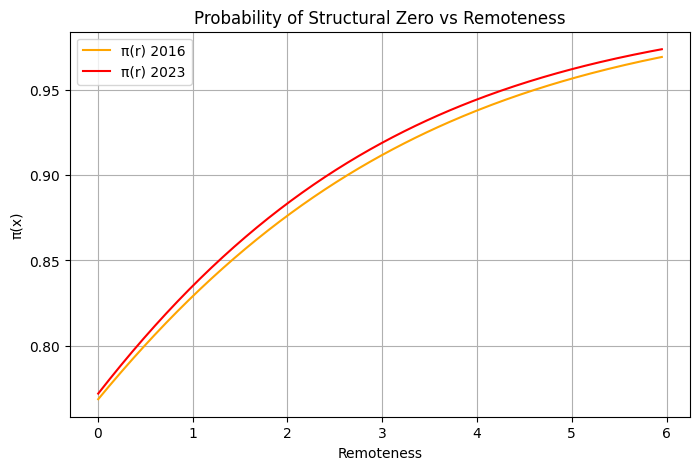

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 构建 x 轴
x_vals = np.linspace(df['remoteness'].min(), df['remoteness'].max(), 200)

# π(x) = sigmoid(inflate_const + inflate_remoteness * x)
inflate_const_16 = zip_result_16.params['inflate_const']
inflate_remoteness_16 = zip_result_16.params['inflate_remoteness']
pi_vals_16 = 1 / (1 + np.exp(-(inflate_const_16 + inflate_remoteness_16 * x_vals)))

inflate_const_23 = zip_result_23.params['inflate_const']
inflate_remoteness_23 = zip_result_23.params['inflate_remoteness']
pi_vals_23 = 1 / (1 + np.exp(-(inflate_const_23 + inflate_remoteness_23 * x_vals)))

# 可视化
plt.figure(figsize=(8,5))
plt.plot(x_vals, pi_vals_16, color='orange', label='π(r) 2016')
plt.plot(x_vals, pi_vals_23, color='red', label='π(r) 2023')
plt.xlabel('Remoteness')
plt.ylabel('π(x)')
plt.title('Probability of Structural Zero vs Remoteness')
plt.grid(True)
plt.legend()
plt.show()

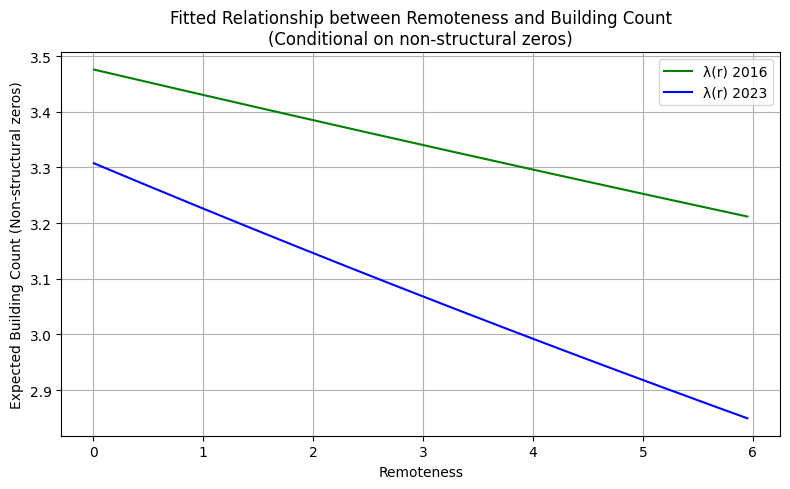

In [32]:
import numpy as np
import matplotlib.pyplot as plt
# 构建 remoteness 的取值范围（比如 0 到 1 之间）
x_vals = np.linspace(df['remoteness'].min(), df['remoteness'].max(), 200)

# params：
const_16 = zip_result_16.params['const']
remoteness_16 = zip_result_16.params['remoteness']
# lambda(x)
lambda_vals_16 = np.exp(const_16 + remoteness_16 * x_vals)
# params：
const_23 = zip_result_23.params['const']
remoteness_23 = zip_result_23.params['remoteness']
# lambda(x)
lambda_vals_23 = np.exp(const_23 + remoteness_23 * x_vals)

# 可视化
plt.figure(figsize=(8, 5))
plt.plot(x_vals, lambda_vals_16, label='λ(r) 2016', color='green')
plt.plot(x_vals, lambda_vals_23, label='λ(r) 2023', color='blue')
plt.xlabel('Remoteness')
plt.ylabel('Expected Building Count (Non-structural zeros)')
plt.title('Fitted Relationship between Remoteness and Building Count\n(Conditional on non-structural zeros)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## geo distribution of pi

In [14]:
import numpy as np

# 模型系数
inflate_const = zip_result.params['inflate_const']
inflate_remoteness = zip_result.params['inflate_remoteness']

# 计算 logit(π(x))
logit_pi = inflate_const + inflate_remoteness * df["remoteness"]

# 计算 π(x)
df["pi_hat"] = 1 / (1 + np.exp(-logit_pi))

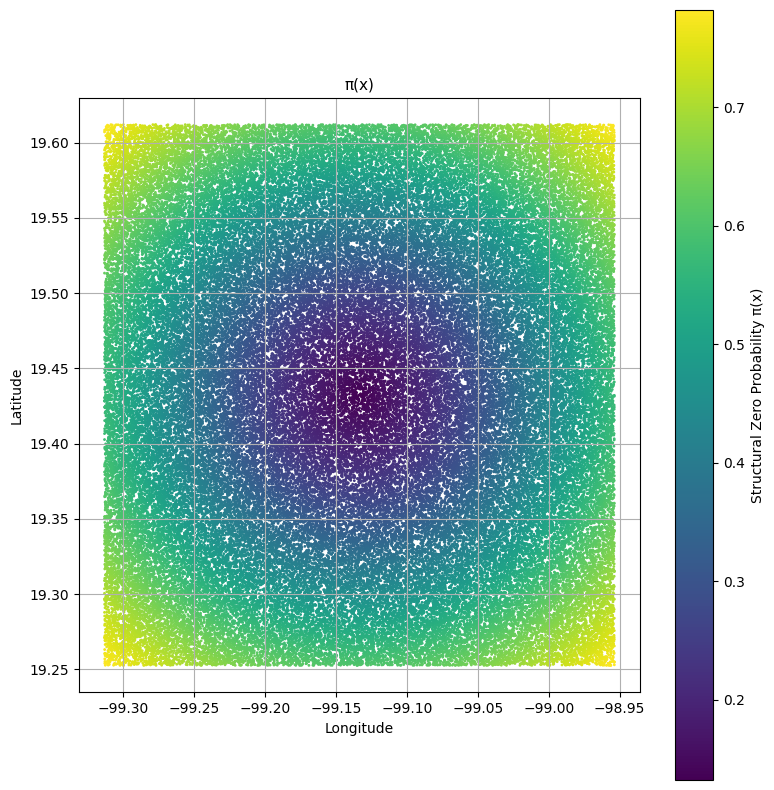

In [15]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# 构造 GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.center_longitude, df.center_latitude),
    crs="EPSG:4326"  # WGS84 经纬度
)

# 画热力图（散点图 + colormap）
fig, ax = plt.subplots(figsize=(8, 8))

# 使用 π 值设定颜色
gdf.plot(
    ax=ax,
    column="pi_hat",
    cmap="viridis",  # 你也可以用 "hot", "coolwarm", "plasma" 等
    markersize=1,
    legend=True,
    legend_kwds={"label": "Structural Zero Probability π(x)"}
)

ax.set_title("π(x)", fontsize=11)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## 最开始的mixture model版本

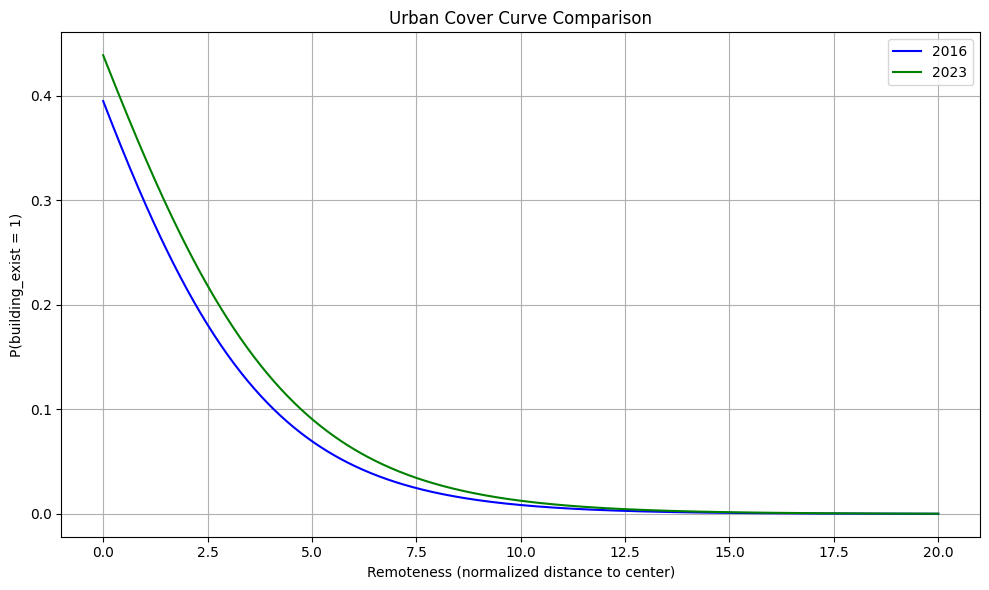

2016 Estimates: {'pi': np.float64(0.9999975393154266), 'kappa': np.float64(-0.4257005558428417), 'delta': np.float64(-0.4332746458220277)}
2016 Confidence Intervals: {'pi': (np.float64(9.192960044979394e-56), np.float64(1.0)), 'kappa': (np.float64(-1.2813428572873906), np.float64(0.42994174560170717)), 'delta': (np.float64(-0.49396425058861504), np.float64(-0.3725850410554403))}
2023 Estimates: {'pi': np.float64(0.9999804870762778), 'kappa': np.float64(-0.24521668935980986), 'delta': np.float64(-0.41160524912559865)}
2023 Confidence Intervals: {'pi': (np.float64(6.974256143293477e-68), np.float64(1.0)), 'kappa': (np.float64(-7.103536535697761), np.float64(6.61310315697814)), 'delta': (np.float64(-0.49191042807280916), np.float64(-0.33130007017838814))}


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
import math

def fit_mixture_logistic(df: pd.DataFrame, population: int):
    df_sample = df.sample(n=100000, random_state=42)
    R = df_sample['distance_to_center'].values / math.sqrt(population) * 1000
    y = df_sample['building_exist'].values

    def neg_log_likelihood(params):
        alpha, kappa, delta = params
        pi = expit(alpha)
        logits = kappa + delta * R
        p = pi * expit(logits)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
        return -ll

    initial = [np.log(0.05 / 0.95), 0.0, -0.01]
    result = minimize(neg_log_likelihood, initial, method='L-BFGS-B')

    if not result.success:
        raise RuntimeError("Fit failed: " + result.message)

    params = result.x
    hess_inv = result.hess_inv.todense() if hasattr(result.hess_inv, 'todense') else np.linalg.inv(result.hess_inv)
    se = np.sqrt(np.diag(hess_inv))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se

    estimates = {
        'pi': expit(params[0]),
        'kappa': params[1],
        'delta': params[2]
    }
    conf_intervals = {
        'pi': (expit(ci_lower[0]), expit(ci_upper[0])),
        'kappa': (ci_lower[1], ci_upper[1]),
        'delta': (ci_lower[2], ci_upper[2])
    }

    return estimates, conf_intervals

def plot_fits(est1, est2, label1="2016", label2="2023"):
    R = np.linspace(0, 20, 500)

    def pred(est, R):
        return est['pi'] * expit(est['kappa'] + est['delta'] * R)

    p1 = pred(est1, R)
    p2 = pred(est2, R)

    plt.figure(figsize=(10, 6))
    plt.plot(R, p1, label=label1, color='blue')
    plt.plot(R, p2, label=label2, color='green')
    plt.xlabel("Remoteness (normalized distance to center)")
    plt.ylabel("P(building_exist = 1)")
    plt.title("Urban Cover Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

pop_2016 = 2573047
pop_2023 = 2573047

# 拟合并提取结果
est16, ci16 = fit_mixture_logistic(anta_16, pop_2016)
est23, ci23 = fit_mixture_logistic(anta_23, pop_2023)

# 可视化对比曲线
plot_fits(est16, est23, "2016", "2023")

# 查看参数和置信区间
print("2016 Estimates:", est16)
print("2016 Confidence Intervals:", ci16)
print("2023 Estimates:", est23)
print("2023 Confidence Intervals:", ci23)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit

def fit_fixed_pi_logistic(df, population, pi_fixed):
    """
    Fit mixture logistic model with fixed pi.
    
    Args:
        df: DataFrame with 'building_exist' (0/1) and 'distance_to_center'
        population: total population for normalization
        pi_fixed: fixed mixing probability pi
    
    Returns:
        dict with estimated parameters (pi, kappa, delta)
    """
    R = df['distance_to_center'].values / np.sqrt(population) * 1000
    y = df['building_exist'].values

    def neg_log_likelihood(params):
        kappa, delta = params
        logits = kappa + delta * R
        p = pi_fixed * expit(logits)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        ll = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.sum(ll)

    initial = [0.0, 0.0]
    bounds = [(None, None), (-5, 5)]
    result = minimize(neg_log_likelihood, initial, method='L-BFGS-B', bounds=bounds)

    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)

    kappa, delta = result.x
    print(f"Fitted delta: {delta}")
    print(f"Fitted kappa: {kappa}")
        
    return {'pi': pi_fixed, 'kappa': kappa, 'delta': delta}

def plot_fixed_pi_fit(estimates1, estimates2, label1="2016", label2="2023"):
    R = np.linspace(0, 20, 500)

    def pred(est):
        return est['pi'] * expit(est['kappa'] + est['delta'] * R)

    p1 = pred(estimates1)
    p2 = pred(estimates2)

    plt.figure(figsize=(10, 6))
    plt.plot(R, p1, label=label1, color='blue')
    plt.plot(R, p2, label=label2, color='red')
    plt.xlabel("Remoteness (km / sqrt(population))")
    plt.ylabel("P(building_exist=1)")
    plt.title("Mixture Logistic Model with Fixed π")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitted delta: -0.6113481867702943
Fitted kappa: 5.724358915900884
Fitted delta: -0.620256157351585
Fitted kappa: 5.92354058361677


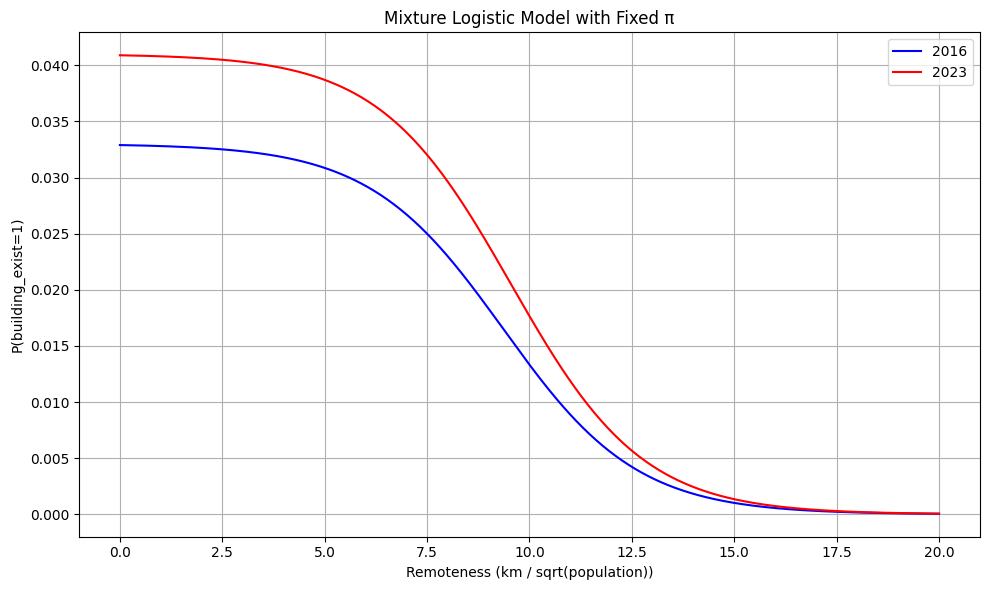

In [27]:
pop_2016 = 2573047
pop_2023 = 2573047

res_16 = fit_fixed_pi_logistic(anta_16, pop_2016, pi_fixed=0.033)
res_23 = fit_fixed_pi_logistic(anta_23, pop_2023, pi_fixed=0.041)

plot_fixed_pi_fit(res_16, res_23)